# 构建目标检测主干框架代码


In [5]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from spektral.layers import GraphConv

def build_model(input_seq_len=132, output_seq_len=64):
    # inputs
    Feature_inputs = L.Input(shape=(10, 4356), name="Nodes_features")
    Feature_inputs_new = L.Dense(660)(Feature_inputs)

    ad_feature_input = L.Input(shape=(132, 33), name="ad_feature_input")
    # adjacency matrix about seq. connectivity
    ad_feature_input_new = L.Dense(64)(ad_feature_input)

    adj_matrix_inputs = L.Input((132, 132), name="adjmatrix")

    attn_adj_matrix_inputs = L.Input((132, 132), name="attn_adj_matrix")
    gcn_1 = GraphConv(
        16,
        activation='tanh',
    )([ad_feature_input_new, adj_matrix_inputs])

    gcn_2 = GraphConv(
        32,
        activation='tanh',
    )([gcn_1, adj_matrix_inputs])

    #     gcn_2 = SeqSelfAttention(attention_activation='relu', attention_type='multiplicative',return_attention=True)(gcn_2)

    #     gcn_2 = GraphAttention(16)([gcn_2, attn_adj_matrix_inputs])
    conv_1 = L.Conv1D(
        16, 16,
        padding='same'
    )(Feature_inputs_new)

    conv_1 = L.LeakyReLU()(conv_1)

    conv_2 = L.Conv1D(
        32, 1,
        padding='same'
    )(conv_1)

    conv_2 = L.LeakyReLU()(conv_2)

    conv_3 = L.Conv1D(
        32, 2,
        padding='same'
    )(conv_1)

    conv_3 = L.LeakyReLU()(conv_3)

    conv_4 = L.Conv1D(
        32, 4,
        padding='same'
    )(conv_1)

    conv_4 = L.LeakyReLU()(conv_4)

    conv_out = L.Concatenate(axis=2)([conv_2, conv_3, conv_4])

    lstm_out = L.Bidirectional(L.LSTM(16, activation='elu', return_sequences=True))(conv_out)
    #     lstm_out, spa_att = SeqSelfAttention(attention_activation='relu', attention_type='multiplicative',
    #                                          return_attention=True)(lstm_out)

    tm_out = L.Flatten()(lstm_out)
    tm_out = L.Dense(132, activation='relu')(tm_out)

    #     linear = L.Dense(32)(ad_feature_input)
    linear = L.Flatten()(ad_feature_input)
    linear = L.Dense(132)(linear)
    tm_out = L.add([tm_out, linear])

    #     gcn_2 = L.Dense(32,activation='relu')(gcn_2)
    gcn_2 = L.Flatten()(gcn_2)

    gcn_2 = L.Dense(132)(gcn_2)

    out = L.Concatenate(axis=1)([tm_out, gcn_2])

    out = L.Dense(132)(out)

    out = L.Reshape((132, 1))(out)

    model = tf.keras.Model(
        inputs=[
            Feature_inputs,
            ad_feature_input,
            adj_matrix_inputs,
            attn_adj_matrix_inputs
        ],
        outputs=out,
    )
    model.sunmmer()
    return model

build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


NameError: name 'ad_feature_input' is not defined

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feature_inputs (InputLayer)     [(None, 10, 4356)]   0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 10, 660)      2875620     Feature_inputs[0][0]             
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 10, 16)       10576       dense_62[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 10, 16)       31696       dense_62[0][0]                   
___________________________________________________________________________________________

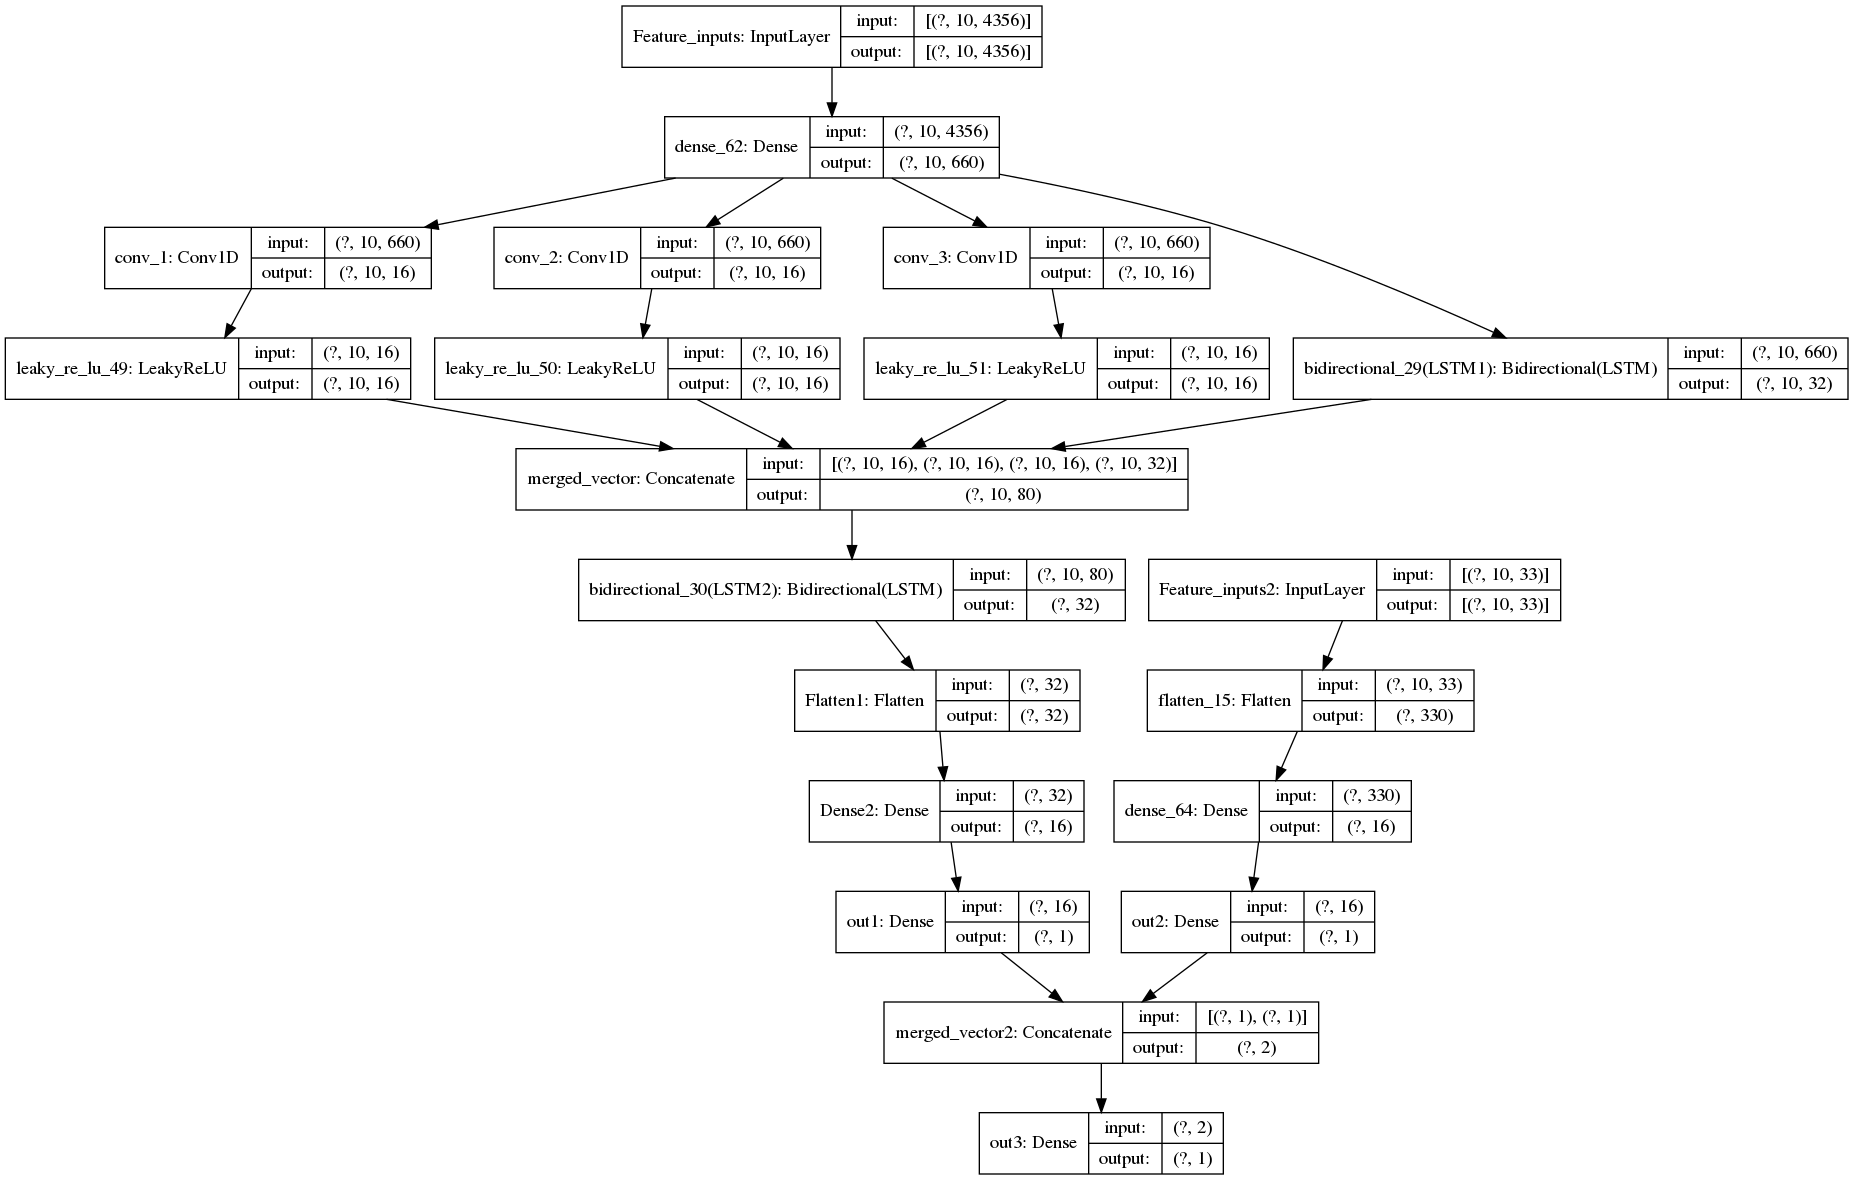

In [44]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf
# from spektral.layers import GraphConv
from tensorflow.keras.models import Model # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers


def build_model(input_seq_len=132, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam'
               ):
        
    # inputs
    Feature_inputs = L.Input(shape=(input_seq_len, 4356), name="Feature_inputs")
    Feature_inputs2 = L.Input(shape=(input_seq_len, 33), name="Feature_inputs2")

    Feature_inputs_new = L.Dense(660)(Feature_inputs)
    Feature_inputs_new2 = L.Dense(64)(Feature_inputs2)

    conv_1 = L.Conv1D(
        16, 1,
        padding='same',name="conv_1")(Feature_inputs_new)
    conv_1_1 = L.LeakyReLU()(conv_1)

    conv_2 = L.Conv1D(
        16,3,
        padding='same',name="conv_2")(Feature_inputs_new)
    conv_2_2 = L.LeakyReLU()(conv_2)

    
    conv_3 = L.Conv1D(
        16,4,
        padding='same',name="conv_3")(Feature_inputs_new)
    conv_3_3 = L.LeakyReLU()(conv_3)



    LSTM1 = L.Bidirectional(LSTM(16,input_shape=(input_seq_len,660),return_sequences=True,name='LSTM1'))(Feature_inputs_new)
    
    merged_vector = concatenate([conv_1_1, conv_2_2, conv_3_3, LSTM1], axis=-1,name="merged_vector")
    LSTM2 = L.Bidirectional(LSTM(16,name='LSTM2'))(merged_vector)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten1)
    out1 = Dense(1, activation='sigmoid',name="out1")(Dense2)
    
    Flatten2 = Flatten()(Feature_inputs2)
    Dense2 = Dense(16)(Flatten2)
    out2 = Dense(1,name='out2')(Dense2)
    
    merged_vector2 = concatenate([out1, out2], axis=-1,name="merged_vector2")
    out3 = Dense(1, activation='sigmoid',name="out3")(merged_vector2)
    
    model = Model(
        inputs=[
            Feature_inputs,Feature_inputs2
        ],
        outputs=out3,
    )
    model.compile(loss=losss,
                  optimizer=optimizerr,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    return model

model = build_model(input_seq_len=10, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam')
tf.keras.utils.plot_model(model,to_file='1.png',show_shapes=True,show_layer_names=True)   

In [103]:

import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [98]:
# data
# https://github.com/XiuzeZhou/NASA/blob/main/RNN%20%26%20LSTM.ipynb
from scipy.io import loadmat
import scipy
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


# data = loadmat(dataFile)


# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split(".")[0]
    filename = filename.split("/")[1]
    print(filename)
    col = data[filename]
    col = col[0][0][0][0]
#     print(col)
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'] = str(col[i][0][0]), int(col[i][1][0])
        d1['time'], d1['data'] = str(convert_to_time(col[i][2][0])), d2
        data.append(d1)
    return data

# 提取锂电池容量
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

# data = loadMat(dataFile,dataName)

# data
# print(data.keys())
# python_y=np.array(data['B0005']) #将matlab数据赋值给python变量
# python_y[0]
# data



In [102]:
dir_path = "nasa_count_data/"
# dataName = "B0005.mat"

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
# dir_path = 'dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    print(len(data))
    Battery[name] = getBatteryCapacity(data)   # 放电时的容量数据

Load Dataset B0005.mat ...
B0005
616
Load Dataset B0006.mat ...
B0006
616
Load Dataset B0007.mat ...
B0007
616
Load Dataset B0018.mat ...
B0018
319


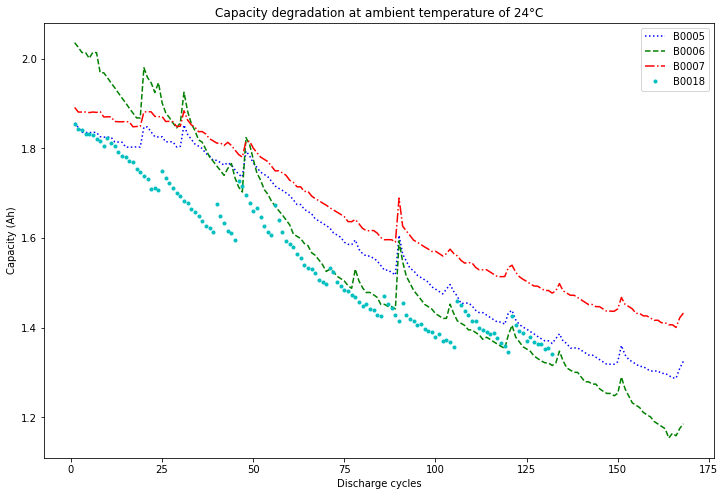

In [100]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [104]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [105]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)
 
    def forward(self, x):           # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x) 
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)      # out shape: (batch_size, n_class=1)
        return out

In [112]:
def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】
    
    
    
    score_list, result_list = [], []
    for i in range(4):
        name = Battery_list[i]  # 样本列表
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size=feature_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = 1,1
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output= model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()    #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)                 # shape: (batch_size, 1, input_size)
                    pred = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)                          #测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)                     #保存输出序列最后一个点的预测值
                y_.append(point_list)                                 #保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list

In [113]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [114]:
window_size = 16
EPOCH = 1000
lr = 0.001           # learning rate
hidden_dim = 256
num_layers = 2
weight_decay = 0.0
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0


SCORE = []
for seed in range(10):
    print('seed: ', seed)
    score_list, _ = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
    print('------------------------------------------------------------------')
    for s in score_list:
        SCORE.append(s)

mlist = ['re', 'mae', 'rmse']
for i in range(3):
    s = [line[i] for line in SCORE]
    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

seed:  0
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1099 | RMSE:0.1247 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.0914 | RMSE:0.1031 | RE:1.0000
epoch:299 | loss:0.0003 | MAE:0.0705 | RMSE:0.0830 | RE:0.0566
epoch:399 | loss:0.0002 | MAE:0.0563 | RMSE:0.0702 | RE:0.0755
sample size: 421
epoch:99 | loss:0.0005 | MAE:0.1216 | RMSE:0.1448 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1183 | RMSE:0.1418 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1050 | RMSE:0.1253 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1055 | RMSE:0.1217 | RE:1.0000
epoch:499 | loss:0.0001 | MAE:0.1188 | RMSE:0.1325 | RE:0.5889
epoch:599 | loss:0.0001 | MAE:0.1353 | RMSE:0.1486 | RE:0.6000
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1338 | RMSE:0.1542 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1168 | RMSE:0.1289 | RE:0.1258
epoch:299 | loss:0.0003 | MAE:0.1216 | RMSE:0.1247 | RE:0.3444
sample size: 457
epoch:99 | loss:0.0007 | MAE:0.0566 | RMSE:0.0665 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.0471 | RMSE:0

epoch:399 | loss:0.0002 | MAE:0.0541 | RMSE:0.0679 | RE:0.0755
sample size: 421
epoch:99 | loss:0.0004 | MAE:0.1104 | RMSE:0.1323 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.1129 | RMSE:0.1350 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1042 | RMSE:0.1234 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1079 | RMSE:0.1234 | RE:0.6333
epoch:499 | loss:0.0001 | MAE:0.1220 | RMSE:0.1357 | RE:0.5889
epoch:599 | loss:0.0001 | MAE:0.1369 | RMSE:0.1504 | RE:0.6000
sample size: 421
epoch:99 | loss:0.0006 | MAE:0.1402 | RMSE:0.1552 | RE:0.2384
epoch:199 | loss:0.0004 | MAE:0.1181 | RMSE:0.1266 | RE:0.2450
sample size: 457
epoch:99 | loss:0.0006 | MAE:0.0484 | RMSE:0.0587 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.0434 | RMSE:0.0528 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.0348 | RMSE:0.0414 | RE:0.3590
epoch:399 | loss:0.0002 | MAE:0.0338 | RMSE:0.0401 | RE:0.2308
epoch:499 | loss:0.0002 | MAE:0.0370 | RMSE:0.0428 | RE:0.2051
epoch:599 | loss:0.0002 | MAE:0.0385 | RMSE:0.0440 | RE:0.1923
epoch:6